### IMPORT PACKAGES



In [260]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import warnings
from tabulate import tabulate
warnings.filterwarnings('ignore')
import re

### LOAD DATA

In [123]:
txn_data = pd.read_excel("./dataset/QVI_transaction_data.xlsx")
purch_behav_data = pd.read_csv("./dataset/QVI_purchase_behaviour.csv")

### EXAMINE DATASETS


#### TRANSACTION DATA

In [124]:
#check data type
txn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


In [125]:
#date is in the wrong data type -  convert to date format -yyyy-mm-dd

txn_data['DATE'] = pd.to_datetime(txn_data['DATE'], origin='1900-01-01',
                                   unit='D')

In [126]:
txn_data['DATE'].head()

0   2018-10-19
1   2019-05-16
2   2019-05-22
3   2018-08-19
4   2018-08-20
Name: DATE, dtype: datetime64[ns]

In [127]:
#txn_data info after conversion

txn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   DATE            264836 non-null  datetime64[ns]
 1   STORE_NBR       264836 non-null  int64         
 2   LYLTY_CARD_NBR  264836 non-null  int64         
 3   TXN_ID          264836 non-null  int64         
 4   PROD_NBR        264836 non-null  int64         
 5   PROD_NAME       264836 non-null  object        
 6   PROD_QTY        264836 non-null  int64         
 7   TOT_SALES       264836 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 16.2+ MB


In [128]:
#check for missing data
txn_data.isnull().sum()

DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64

In [129]:
#check for duplicates
txn_data.duplicated().sum()

np.int64(1)

In [130]:
#check duplicated data - 
txn_data[txn_data.duplicated()]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
124845,2018-10-03,107,107024,108462,45,Smiths Thinly Cut Roast Chicken 175g,2,6.0


In [131]:
#remove duplicates
txn_data=txn_data.drop_duplicates()

txn_data.duplicated().sum()

np.int64(0)

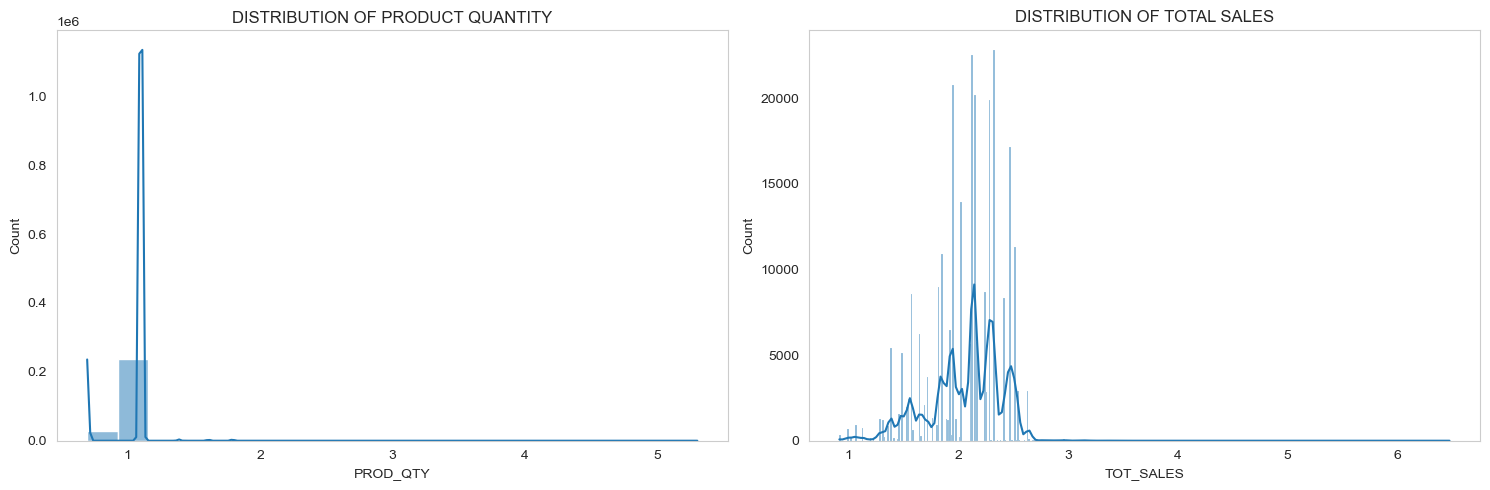

In [132]:
#check for outliers


#Before checking outliers, the distribution of data must be understood

#vizualize using charts
sns.set_style("whitegrid", {'axes.grid' : False})
fig, axes = plt.subplots(1,2, figsize=(15,5))


#define plots

#subplot 1- prod_qty
sns.histplot(data=np.log1p(txn_data['PROD_QTY']),ax=axes[0],kde=True)
axes[0].set_title("DISTRIBUTION OF PRODUCT QUANTITY",)

#subplot 2- total_sales
sns.histplot(data=np.log1p(txn_data['TOT_SALES']), ax=axes[1],kde=True)
axes[1].set_title("DISTRIBUTION OF TOTAL SALES")

#layout
plt.tight_layout()
plt.show()

In [146]:
#calculate outliers using quantiles
Q1 = txn_data['TOT_SALES'].quantile(0.25)
Q3 = txn_data['TOT_SALES'].quantile(0.75)
IQR = Q3 - Q1  # Interquartile range

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(IQR)

3.799999999999999


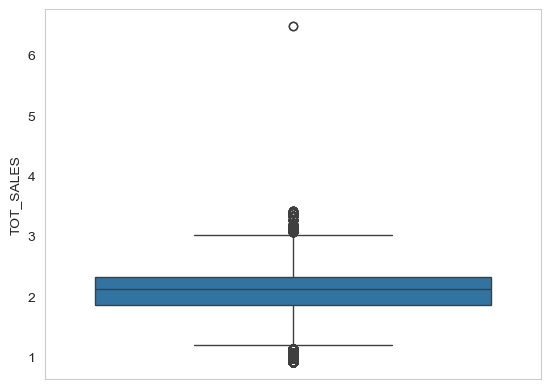

In [134]:
#outlier viz
sns.boxplot(data=np.log1p(txn_data['TOT_SALES']))
plt.show()

### EXAMINE CUSTOMER DATA


In [135]:
#info on customer dataset
purch_behav_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [136]:
#check for missing data
purch_behav_data.isnull().sum()

LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [137]:
#check for duplicates
purch_behav_data.duplicated().sum()

np.int64(0)

### MERGE DATA

In [138]:
#merge
customer_data = pd.merge(txn_data,purch_behav_data, how='outer')

#display
customer_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-19,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,YOUNG SINGLES/COUPLES,Premium
1,2018-09-18,1,1002,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,YOUNG SINGLES/COUPLES,Mainstream
2,2019-03-09,1,1003,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,YOUNG FAMILIES,Budget
3,2019-03-10,1,1003,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,YOUNG FAMILIES,Budget
4,2018-11-04,1,1004,5,96,WW Original Stacked Chips 160g,1,1.9,OLDER SINGLES/COUPLES,Mainstream


### DATA PREPARATION

##### REMOVE PRODUCTS THAT ARE NOT CHIPS

In [139]:
customer_data['PROD_NAME'] = customer_data['PROD_NAME'].str.lower()

In [140]:
cust_chips_data = customer_data[customer_data['PROD_NAME'].str.contains('chip')]
cust_chips_data.tail()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER
264813,2018-12-01,77,2330251,236747,14,smiths crnkle chip orgnl big bag 380g,2,11.8,RETIREES,Budget
264817,2019-06-20,77,2330291,236754,83,ww d/style chip sea salt 200g,1,1.9,OLDER SINGLES/COUPLES,Mainstream
264818,2018-11-11,77,2330311,236755,90,tostitos smoked chipotle 175g,1,4.4,YOUNG SINGLES/COUPLES,Budget
264827,2018-12-19,88,2370581,240317,93,doritos corn chip southern chicken 150g,2,7.8,OLDER SINGLES/COUPLES,Budget
264834,2018-12-16,88,2373711,241815,16,smiths crinkle chips salt & vinegar 330g,2,11.4,YOUNG SINGLES/COUPLES,Mainstream


### REMOVE OUTLIERS



In [148]:
#FILTER DATA

cust_chips_data = cust_chips_data[(cust_chips_data['TOT_SALES']>= lower_bound) & (cust_chips_data['TOT_SALES'] <= upper_bound)]

cust_chips_data.shape

(74422, 12)

### FEATURE ENGINEERING

#### CREATE NEW COLUMN TO STORE CHIP SIZE

In [149]:
cust_chips_data['CHIP_SIZE(g)']= cust_chips_data['PROD_NAME'].str.extract(r'(\d+)')


cust_chips_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER,CHIP_SIZE(g),CHIP_BRAND
0,2018-10-19,1,1000,1,5,natural chip compny seasalt175g,2,6.0,YOUNG SINGLES/COUPLES,Premium,175,natural compny seasalt
3,2019-03-10,1,1003,4,106,natural chipco hony soy chckn175g,1,3.0,YOUNG FAMILIES,Budget,175,natural chipco hony soy chckn
4,2018-11-04,1,1004,5,96,ww original stacked chips 160g,1,1.9,OLDER SINGLES/COUPLES,Mainstream,160,ww original stacked chips
14,2018-12-21,1,1011,15,1,smiths crinkle cut chips barbecue 170g,1,2.9,OLDER SINGLES/COUPLES,Mainstream,170,smiths crinkle cut chips barbecue
17,2019-03-06,1,1013,18,93,doritos corn chip southern chicken 150g,1,3.9,RETIREES,Budget,150,doritos corn southern chicken


#### CONVERT CHIP_SIZE TO INT

In [150]:
cust_chips_data['CHIP_SIZE(g)'] = cust_chips_data['CHIP_SIZE(g)'].astype(int)
cust_chips_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74422 entries, 0 to 264834
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DATE              74422 non-null  datetime64[ns]
 1   STORE_NBR         74422 non-null  int64         
 2   LYLTY_CARD_NBR    74422 non-null  int64         
 3   TXN_ID            74422 non-null  int64         
 4   PROD_NBR          74422 non-null  int64         
 5   PROD_NAME         74422 non-null  object        
 6   PROD_QTY          74422 non-null  int64         
 7   TOT_SALES         74422 non-null  float64       
 8   LIFESTAGE         74422 non-null  object        
 9   PREMIUM_CUSTOMER  74422 non-null  object        
 10  CHIP_SIZE(g)      74422 non-null  int64         
 11  CHIP_BRAND        74422 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(6), object(4)
memory usage: 7.4+ MB


#### EXTRACT CHIP BRAND NAME



In [151]:
#extract everything but 'chip' string and chip size '100g'

cust_chips_data['CHIP_BRAND'] = cust_chips_data['PROD_NAME'].str.replace(r'\bchip\b|\d+[a-z]?','' ,regex=True).str.strip()
cust_chips_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER,CHIP_SIZE(g),CHIP_BRAND
0,2018-10-19,1,1000,1,5,natural chip compny seasalt175g,2,6.0,YOUNG SINGLES/COUPLES,Premium,175,natural compny seasalt
3,2019-03-10,1,1003,4,106,natural chipco hony soy chckn175g,1,3.0,YOUNG FAMILIES,Budget,175,natural chipco hony soy chckn
4,2018-11-04,1,1004,5,96,ww original stacked chips 160g,1,1.9,OLDER SINGLES/COUPLES,Mainstream,160,ww original stacked chips
14,2018-12-21,1,1011,15,1,smiths crinkle cut chips barbecue 170g,1,2.9,OLDER SINGLES/COUPLES,Mainstream,170,smiths crinkle cut chips barbecue
17,2019-03-06,1,1013,18,93,doritos corn chip southern chicken 150g,1,3.9,RETIREES,Budget,150,doritos corn southern chicken


###  ANALYSIS 

##### The aim of this analysis is to understand customer chip purchasing behavior.

#### CUSTOMER SEGMENT - DEMOGRAPHIC SEGMENTATION

#### YEARLY ANALYSIS

1. What are the top 3 highest selling chip brands by total sales across our lifestage groups over the last year?


In [ ]:
cust_chips_cs1= cust_chips_data[cust_chips_data['DATE'].dt.year == 2019]

#highest total sales- grouped by lifestage
cs1 = cust_chips_cs1.groupby(['LIFESTAGE','CHIP_BRAND']).agg( 
    highest_sales=pd.NamedAgg(column='TOT_SALES',aggfunc="sum")).reset_index(
        
    ).sort_values(['LIFESTAGE','highest_sales'],ascending=False).groupby('LIFESTAGE', group_keys=False).head(3)
cs1


,LIFESTAGE,CHIP_BRAND,highest_sales
219,YOUNG SINGLES/COUPLES,smiths crnkle orgnl big bag,2584.2
214,YOUNG SINGLES/COUPLES,smiths crinkle chips salt & vinegar,2337.0
205,YOUNG SINGLES/COUPLES,doritos corn chips original,2050.4
181,YOUNG FAMILIES,smiths crinkle chips salt & vinegar,2941.2
186,YOUNG FAMILIES,smiths crnkle orgnl big bag,2719.9
192,YOUNG FAMILIES,tostitos smoked chipotle,2345.2
153,RETIREES,smiths crnkle orgnl big bag,3457.4
148,RETIREES,smiths crinkle chips salt & vinegar,3402.9
138,RETIREES,doritos corn chips nacho cheese,2648.8
120,OLDER SINGLES/COUPLES,smiths crnkle orgnl big bag,3557.7


### VIZUALIZATION

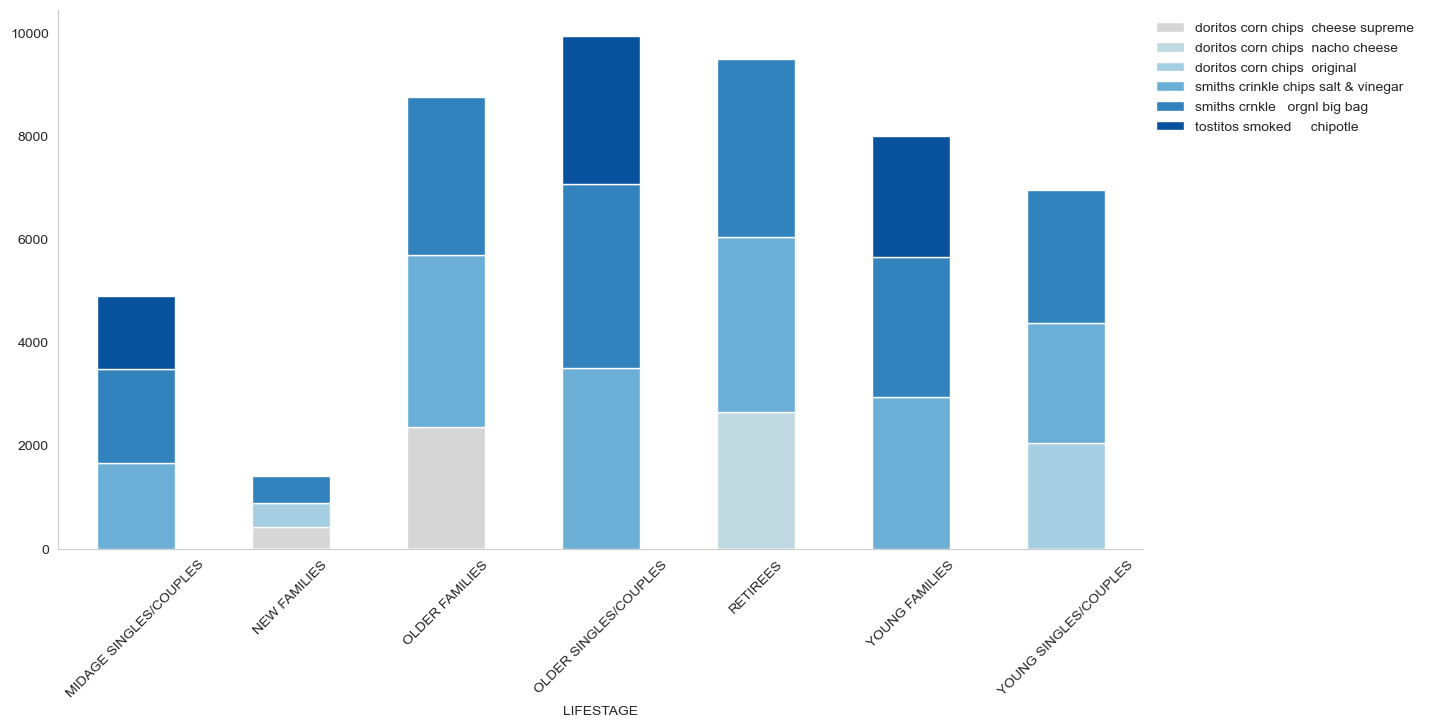

In [263]:
sns.set_style("whitegrid",{'axes.grid': False}) #remove grid lines for clear background

cs1_pivot = cs1.pivot(index='LIFESTAGE',columns='CHIP_BRAND', values='highest_sales')

#set custom colors
custom_blues = LinearSegmentedColormap.from_list("custom_blues", [
    "#d6d6d6",  # Light Grey (instead of White)
    "#c0d8e0",  # Pale Blue-Grey
    "#a6cee3",  # Light Blue
    "#6baed6",  # Medium Light Blue
    "#3182bd",  # Medium Blue
    "#08519c"   # Dark Blue
], N=256)

#plot setting
ax = cs1_pivot.plot(kind='bar',stacked=True, figsize=(14,7),cmap=custom_blues)

#titles and legends settings
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(bbox_to_anchor=(1,1),frameon=False)

#xticks
plt.xticks(rotation=45)

plt.show()

2. What are the 5 stores had the highest sale of chips in the last year?




In [261]:
#filter data for 2019
cs2_data = cust_chips_data[cust_chips_data['DATE'].dt.year == 2019]

#aggregate cs2_data
cs2_data_plot = cs2_data.groupby('STORE_NBR').agg(
    store_sales=pd.NamedAgg('TOT_SALES', aggfunc='sum')
).reset_index().sort_values(by='store_sales',ascending=False).head()
#set style for clean viz
sns.set_style("whitegrid",{"axes.grid":False})

#create plot
table = tabulate(cs2_data_plot, headers=['Store Number', 'Total Sales for 2019'], tablefmt='pretty_fmt')
print(table)

       Store Number    Total Sales for 2019
---  --------------  ----------------------
159             165                  2182.7
217             226                  2060.5
 83              88                  1999.5
 37              40                  1922.4
228             237                  1900.6


### VIZUALIZATION



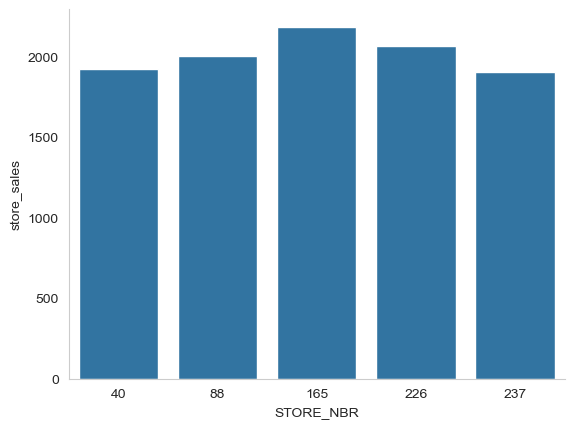

In [ ]:
sns.set_style("whitegrid",{"axes.grid":False})

#create plot
ax =sns.barplot(data=cs2_data_plot,x='STORE_NBR',y='store_sales')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#### QUARTELY ANALYSIS
